# WikiTLDR

A summarization/simplification dataset

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
conn = sqlite3.connect('../raw_data/simple_en_wiki.db')
cursor = conn.cursor()

df = pd.read_sql_query("SELECT * FROM articles", conn)
df.drop(columns=['id'], inplace=True)
df.head()

,title,input_text,target_text
0,Johan August Arfwedson,Johan August Arfwedson (12 January 1792 – 28 O...,Johan August Arfwedson (12 January 1792 – 28 O...
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,..."
2,Moundou,Moundou (Arabic: موندو) is the second-largest ...,Moundou is the capital of the Logone Occidenta...
3,Kamrieng District,Kamrieng (Khmer: កំរៀង) is a district (srok) o...,Kamrieng District (Khmer: កំរៀង) is a district...
4,Mother 1 + 2,Mother (known as EarthBound outside Japan) is ...,Mother 1 + 2 is a video game for the Game Boy ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38295 entries, 0 to 38294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        38295 non-null  object
 1   input_text   38295 non-null  object
 2   target_text  38163 non-null  object
dtypes: object(3)
memory usage: 897.7+ KB


In [4]:
df.isna().sum()

,0
title,0
input_text,0
target_text,132


We replace empty strings `""` with nulls. Because they *are* null values.

In [5]:
df.replace("", np.nan, inplace=True)

In [6]:
df.isna().sum()

,0
title,0
input_text,0
target_text,167


In [7]:
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

3876

In [9]:
df[df.duplicated()]

,title,input_text,target_text
1515,Mizrahi music,Mizrahi music (Hebrew: מוזיקה מזרחית muzika mi...,Mizrahi music (Hebrew: מוזיקה מזרחית) is a mus...
1683,Fantaisie-Impromptu,Frédéric Chopin's Fantaisie-Impromptu (Polish:...,Frédéric Chopin's Fantaisie-Impromptu in C♯ mi...
1769,"Stonewall County, Texas",Stonewall County is a county located in the U....,Stonewall County is a county in the U.S. state...
1844,Hanoi,Hanoi (Vietnamese: Hà Nội ) is the capital and...,Hanoi (Vietnamese: Hà Nội) is the capital of V...
1986,"Saint-Martin, Gers",Saint-Martin (French pronunciation: [sɛ̃ maʁtɛ...,Saint-Martin is a commune in the Gers departme...
...,...,...,...
38251,K. Balachander filmography,This following is the list of films to which K...,"K. Balachander has written, directed nearly 80..."
38266,Magda Amo Rius,"Magda Amo Rius (born July 23, 1973, in Barcelo...","Magda Amo Rius (born July 23, 1973 in Barcelon..."
38272,Ohio Players,"Ohio Players are an American funk band, most p...",The Ohio Players were a funk and R&B band from...
38273,Valbonne,Valbonne (French pronunciation: [valbɔn]; Occi...,Valbonne is a commune. It is found in the regi...


In [10]:
df[df["title"] == "Warangal"]

,title,input_text,target_text
3718,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."
16250,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.info()
print("Null values: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 34252 entries, 0 to 38294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        34252 non-null  object
 1   input_text   34252 non-null  object
 2   target_text  34252 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
Null values:  0
Duplicates:  0


Replace consecutive newlines `\n` with a single one.

In [13]:
print(df["input_text"].str.contains(r"\n{2,}", regex=True).sum())
print(df["target_text"].str.contains(r"\n{2,}", regex=True).sum())

8875
1033


In [14]:
df["input_text"] = df["input_text"].str.replace(r"\n{2,}", "\n", regex=True)
df["target_text"] = df["target_text"].str.replace(r"\n{2,}", "\n", regex=True)

## Compression Ratio

This is the ratio of the length of the simplified text and the standard English text.

$$
\text{compression\_ratio} = \frac{\text{Length of simplified text}}{\text{Length of standard English text}}
$$

Larger compression ratio values mean larger summaries.

In [15]:
df["compression_ratio"] = df["target_text"].str.len() / \
    df["input_text"].str.len()

In [16]:
df["compression_ratio"].describe()

,compression_ratio
count,34252.000000
mean,0.841302
std,1.313101
min,0.004037
25%,0.292763
50%,0.586799
75%,0.979604
max,82.583333


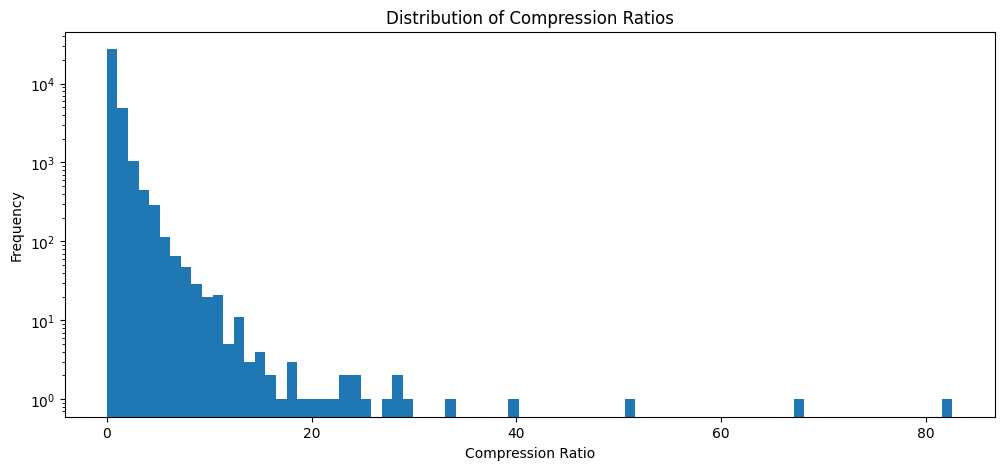

In [17]:
plt.figure(figsize=(12, 5))
plt.hist(df['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [18]:
largest = df.iloc[np.argmax(df["compression_ratio"])]
print(largest)
print(largest["input_text"])
print()
print(largest["target_text"])

title                                                           S.A.S.
input_text                                    SAS or Sas may refer to:
target_text          The S.A.S. or Special Air Service, is a Specia...
compression_ratio                                            82.583333
Name: 37696, dtype: object
SAS or Sas may refer to:

The S.A.S. or Special Air Service, is a Special Operations Organisation of the British Army. It was founded in 1941 to attack behind the German line of defence in North Africa, in World War II. They are one of the best schooled units in the world, that makes them very valuable. There are about 500 active SAS soldiers.
The SAS is a secret organisation. Its members often do not tell anyone except close family that they are in it. The British Ministry of Defence (MOD) rarely speaks of the SAS and mission details are never released until much later.
The badge of the organisation was originally designed as a flaming sword of Damocles but ended up as a winged d

In [19]:
df = df[(df["compression_ratio"] > 0.2) & (df["compression_ratio"] < 1.2)]

Articles titled "List of x things" on Wikipedia are not considered proper summarizations because they typically consist of enumerations rather than narrative content. These lists do not provide much context or detailed information to summarize.

In [20]:
df.drop(df[df["title"].str.contains("^List of", regex=True)].index, inplace=True)

In [21]:
large_summaries = df[df["compression_ratio"] > 1]

In [22]:
large_summaries.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio
385,Zip drive,The Zip drive is a removable floppy disk stora...,The Zip drive is a data storage device. The co...,1.199732
14029,Tanjong Pagar MRT station,Tanjong Pagar MRT station is an underground Ma...,Tanjong Pagar MRT Station (EW15) is an undergr...,1.199541
3393,I've Been to the Mountaintop,"""I've Been to the Mountaintop"" is the popular ...",I've Been to the Mountaintop is the name of th...,1.199187
2102,Carlos Squeo,"Carlos Vicente Squeo (4 June 1948 in Dock Sud,...","Carlos Vicente Squeo (4 June 1948 in Dock Sud,...",1.199187
2712,Fixed-point theorem,"In mathematics, a fixed-point theorem is a res...","In mathematics, a fixed-point theorem is a the...",1.199029


In [23]:
len(large_summaries)

2444

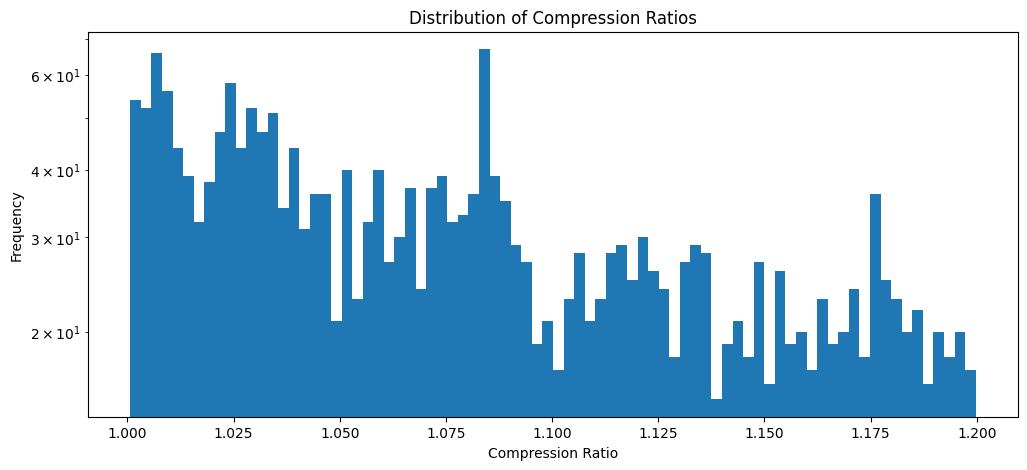

In [24]:
plt.figure(figsize=(12, 5))
plt.hist(large_summaries['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [25]:
sample = large_summaries.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([1983], dtype='int64')
Ana de Sousa (born 18 August 1969) is a Portuguese archer. She competed at the 1988 Summer Olympics and the 1992 Summer Olympics.
----------------------------------------Target Text----------------------------------------
Ana de Sousa (born 18 August 1969) is a Portuguese archer. De Sousa competed at the 1988 Summer Olympics and the 1992 Summer Olympics.


In [26]:
refer_to_articles = df["input_text"].str.contains(r"may refer to",
                                                  case=False,
                                                  regex=True)
df = df[~refer_to_articles]

In [27]:
df["compression_ratio"].describe()

,compression_ratio
count,23751.000000
mean,0.612055
std,0.277431
min,0.200065
25%,0.365253
50%,0.581197
75%,0.844174
max,1.199732


In [28]:
# minimum length thresholds
min_input_words = 10
min_target_words = 5

min_compression_ratio = 0.2
max_compression_ratio = 1.


filtered_df = df[
    (df['input_text'].str.split().str.len() >= min_input_words) &
    (df['target_text'].str.split().str.len() >= min_target_words)
    # (df['compression_ratio'] >= min_compression_ratio) &
    # (df['compression_ratio'] <= max_compression_ratio)
]

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")
print(f"Removed entries: {len(df) - len(filtered_df)}")

Original dataset size: 23751
Filtered dataset size: 23749
Removed entries: 2


In [29]:
filtered_df.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio
385,Zip drive,The Zip drive is a removable floppy disk stora...,The Zip drive is a data storage device. The co...,1.199732
14029,Tanjong Pagar MRT station,Tanjong Pagar MRT station is an underground Ma...,Tanjong Pagar MRT Station (EW15) is an undergr...,1.199541
3393,I've Been to the Mountaintop,"""I've Been to the Mountaintop"" is the popular ...",I've Been to the Mountaintop is the name of th...,1.199187
2102,Carlos Squeo,"Carlos Vicente Squeo (4 June 1948 in Dock Sud,...","Carlos Vicente Squeo (4 June 1948 in Dock Sud,...",1.199187
2712,Fixed-point theorem,"In mathematics, a fixed-point theorem is a res...","In mathematics, a fixed-point theorem is a the...",1.199029


In [30]:
filtered_df.info()
print()
filtered_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 23749 entries, 0 to 38293
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              23749 non-null  object 
 1   input_text         23749 non-null  object 
 2   target_text        23749 non-null  object 
 3   compression_ratio  23749 non-null  float64
dtypes: float64(1), object(3)
memory usage: 927.7+ KB



,compression_ratio
count,23749.000000
mean,0.612022
std,0.277420
min,0.200065
25%,0.365209
50%,0.581126
75%,0.844046
max,1.199732


In [31]:
sample = filtered_df.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([4220], dtype='int64')
Zhuchengtyrannus (meaning "Zhucheng tyrant") is a genus of tyrannosaurid theropod dinosaur known from the Campanian stage of the Late Cretaceous of Shandong Province, China. It belongs to the subfamily Tyrannosaurinae, and contains a single species, Zhuchengtyrannus magnus.
----------------------------------------Target Text----------------------------------------
Zhuchengtyrannus (meaning "Zhucheng tyrant") was a genus of tyrannosaurids from the Upper Cretaceous of Shandong, China. Its only species is Zhuchengtyrannus magnus.


Text within parenthesis may contain unicode values like non English charactes. Like Japanese kanji or greek letters.

It may be lazy but I'd rather remove the parenthesis and whatever's inside it. (i think this is bad)

In [32]:
# find contents within parentheses
def rm_parentheses_content(text):
    return re.sub(r"\([^)]*\)", "", text)


# remove them
filtered_df["input_text"] = filtered_df["input_text"].apply(
    rm_parentheses_content)
filtered_df["target_text"] = filtered_df["target_text"].apply(
    rm_parentheses_content)

<ipython-input-32-e7b3b5f10523>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["input_text"] = filtered_df["input_text"].apply(
<ipython-input-32-e7b3b5f10523>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["target_text"] = filtered_df["target_text"].apply(


In [33]:
filtered_df

,title,input_text,target_text,compression_ratio
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577
3,Kamrieng District,Kamrieng is a district of Battambang provinc...,Kamrieng District is a district of Battamban...,1.094737
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047
...,...,...,...,...
38288,Shabestar,Shabestar is a city in the Central District o...,Shabestar is a city and is the capital of Sha...,0.461874
38290,Jack Garfein,Jakob Garfein was an American film and theatr...,Jack Garfein was an American director and act...,0.426441
38291,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,0.870504
38292,Limony,Limony is a commune in the Ardèche department...,Limony is a commune in the Ardèche départemen...,0.582609


In [34]:
%pip install -q textstat rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.7 MB/s eta 0:00:00


In [35]:
from textstat import textstat
from rouge import Rouge

In [36]:
# calculate readability score
filtered_df['readability_score'] = filtered_df['target_text'].apply(
    textstat.flesch_reading_ease)

<ipython-input-36-066c925929bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['readability_score'] = filtered_df['target_text'].apply(


In [37]:
# calculating ROUGE scores
rouge = Rouge()


def calculate_rouge(row):
    scores = rouge.get_scores(row['target_text'], row['input_text'])[0]
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']


filtered_df[['rouge-1', 'rouge-2', 'rouge-l']
            ] = filtered_df.apply(calculate_rouge, axis=1, result_type='expand')

filtered_df.head()

<ipython-input-37-aaa21f1d937f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['rouge-1', 'rouge-2', 'rouge-l']
<ipython-input-37-aaa21f1d937f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['rouge-1', 'rouge-2', 'rouge-l']
<ipython-input-37-aaa21f1d937f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,title,input_text,target_text,compression_ratio,readability_score,rouge-1,rouge-2,rouge-l
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500,53.88,0.864865,0.756757,0.864865
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987,58.62,0.224719,0.051282,0.224719
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577,86.71,0.538462,0.333333,0.538462
3,Kamrieng District,Kamrieng is a district of Battambang provinc...,Kamrieng District is a district of Battamban...,1.094737,26.47,0.857143,0.631579,0.857143
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,68.77,0.465116,0.285714,0.465116


In [38]:
min_readability_score = 40

filtered_df = filtered_df[
    (filtered_df['readability_score'] >= min_readability_score)
]

In [39]:
filtered_df.info()
filtered_df

<class 'pandas.core.frame.DataFrame'>
Index: 19975 entries, 0 to 38293
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              19975 non-null  object 
 1   input_text         19975 non-null  object 
 2   target_text        19975 non-null  object 
 3   compression_ratio  19975 non-null  float64
 4   readability_score  19975 non-null  float64
 5   rouge-1            19975 non-null  float64
 6   rouge-2            19975 non-null  float64
 7   rouge-l            19975 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.4+ MB


,title,input_text,target_text,compression_ratio,readability_score,rouge-1,rouge-2,rouge-l
0,Johan August Arfwedson,Johan August Arfwedson was a Swedish chemist...,Johan August Arfwedson was a Swedish chemist....,0.862500,53.88,0.864865,0.756757,0.864865
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987,58.62,0.224719,0.051282,0.224719
2,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577,86.71,0.538462,0.333333,0.538462
6,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,68.77,0.465116,0.285714,0.465116
8,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.628272,43.69,0.470588,0.303797,0.470588
...,...,...,...,...,...,...,...,...
38288,Shabestar,Shabestar is a city in the Central District o...,Shabestar is a city and is the capital of Sha...,0.461874,67.76,0.297297,0.175824,0.270270
38290,Jack Garfein,Jakob Garfein was an American film and theatr...,Jack Garfein was an American director and act...,0.426441,66.33,0.195440,0.050808,0.182410
38291,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,0.870504,69.79,0.814815,0.466667,0.666667
38292,Limony,Limony is a commune in the Ardèche department...,Limony is a commune in the Ardèche départemen...,0.582609,68.77,0.900000,0.800000,0.900000


In [43]:
# filter based on ROUGE scores
min_rouge_2 = 0.2
max_rouge_2 = 0.6
min_rouge_l = 0.3
max_rouge_l = 0.8

print(f"Original dataset size: {len(filtered_df)}")

filtered_df = filtered_df[
    (filtered_df['rouge-2'] >= min_rouge_2) &
    (filtered_df['rouge-2'] <= max_rouge_2) &
    (filtered_df['rouge-l'] >= min_rouge_l) &
    (filtered_df['rouge-l'] <= max_rouge_l)
]

print(f"Filtered dataset size: {len(filtered_df)}")
# do da math

Original dataset size: 19975
Filtered dataset size: 9465


quality or quantity tradeoff

In [ ]:
filtered_df.to_json("../processed_data/data.jsonl", orient="records", lines=True)

In [3]:
df = pd.read_json("../processed_data/data.jsonl", lines=True)

In [4]:
df

,title,input_text,target_text,compression_ratio,readability_score,rouge-1,rouge-2,rouge-l
0,Moundou,Moundou is the second-largest city in Chad an...,Moundou is the capital of the Logone Occidenta...,0.617577,86.71,0.538462,0.333333,0.538462
1,"Lone Rock, Iowa","Lone Rock is a city in Kossuth County, Iowa, U...",Lone Rock is a city in Iowa in the United States.,0.230047,68.77,0.465116,0.285714,0.465116
2,Japan Mint,The Japan Mint is an Independent Administrati...,The Japan Mint is an Incorporated Administrat...,0.628272,43.69,0.470588,0.303797,0.470588
3,Arkhangelsk Oblast,Arkhangelsk Oblast is a federal subject of Ru...,Arkhangelsk Oblast is one of the federal subj...,0.505747,50.12,0.483660,0.270270,0.483660
4,Fred Kida,Fred Kida was a Japanese-American comic boo...,Fred Kida was a Japanese-American comic book...,0.530488,57.27,0.554622,0.418301,0.554622
...,...,...,...,...,...,...,...,...
9460,Nomain,Nomain is a commune in the Nord department in...,Nomain is a commune in Nord in north France. I...,0.840426,97.70,0.583333,0.333333,0.583333
9461,Grand Duchess Xenia Alexandrovna of Russia,Grand Duchess Xenia Alexandrovna of Russia wa...,Grand Duchess Xenia Alexandrovna of Russia wa...,0.457792,56.76,0.432836,0.225989,0.417910
9462,Marco Brito,Marco Luiz Brito is a retired Brazilian footb...,Marco Luiz Brito is a former Brazilian footba...,1.054795,45.42,0.705882,0.533333,0.705882
9463,Balinghem,Balinghem is a commune in the Pas-de-Calais d...,Balinghem is a commune. It is found in the reg...,0.870504,69.79,0.814815,0.466667,0.666667
